## Load Hi-C data and gene information

In [2]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib.patches as patches
from HiC_GenomeObject2 import HiC_genomeObject
import numpy as np
import pandas as pd
import os
import re
import pickle

%matplotlib inline

# for making PDF files
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

# genome information
genbankfile = './genome_info/NC_022898.gbk'
operonfile = ('./genome_info/All_transcription_units_of_B._subtilis_PY79_BioSubCyc.csv')

self = HiC_genomeObject()
self.set_chromosome_length(4033459)
self.load_genBank_annotation(genbankfile)
self.load_operonStructure(operonfile)

# load data 
data_dir = './data/'
data_info = pd.read_excel('./data/Data_info.xls') 
data_info.sort_values('ParS position (bp)',inplace=True)

for idx in range(len(data_info)): 
    key = data_info['key'].iloc[idx] # get the preferred the name for referencing the data 
    hic_file_name = os.path.join(data_dir,data_info['filename'].iloc[idx]) 
    self.load_text_HiC_Map(hic_file_name,key=key) # load the Hi-C file
    self.set_parS_sites(key,[data_info['ParS position (bp)'].iloc[idx]]) # set locations of the parS sites

# prepares a Pandas DataFrame for calculating extrusion trajectories
self.computeDScore()


## Compute extrustion trajectory using gene direction and positions model

In [3]:
# options of data to plot
self.HiC_genomDict.keys()

dict_keys(['chrmLen', 'rRNA', 'tRNA', 'gene', 'operons', 'parS+4', 'parS+26', 'parS+91', 'parS+117', 'parS-117', 'parS-94', 'parS-59', 'parS-27', 'parS-1', 'parS-94+91', 'dscoreR', 'dscoreT', 'dscoreO'])

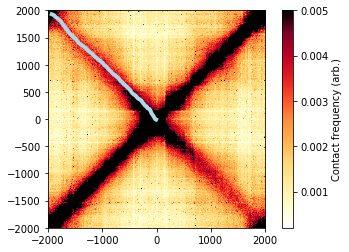

In [4]:
key =  'parS-1'#
self.show_heatmap(key,vmax=0.005,showShifted=True)

rho = 25
gamma = 3.5
tau = gamma
extrusion_time = 38*60 # in seconds
x_clockwise, x_cclockwise, tq, X_coords, Y_coords, vmax  = \
        self.doExtrusionTrace(key,gamma=gamma,rho=rho,tau=tau,\
                              timeCutoff=extrusion_time,showShifted=True,doPeriodic=True)

plt.draw()
plt.ylim([-2000,2000])
plt.xlim([-2000,2000])
cbar = plt.colorbar()
cbar.set_label('Contact frequency (arb.)', rotation=90)

## Example of goodness of fit of various extrusion trajectories

/home/hbrandao/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/hbrandao/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


(1, 100)

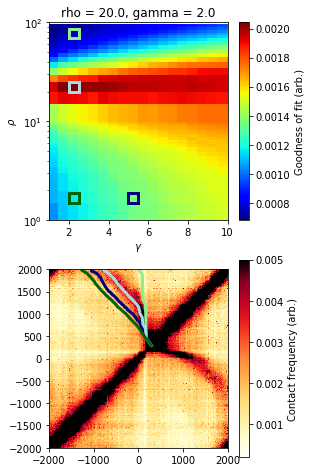

In [5]:
key = 'parS+26'

# load pre-computed values of extrusion "goodness of fit" for varying values of model parameters
df = pickle.load(open('./optimization_data/gammaRhoSweep_Mix0_{}.pkl'.format(key),'rb') )
rho_vals =df['rho_vals']
gamma_vals=df['gamma_vals'][0:20] 
hiSum_list=df['hiSum_list'][:,0:20]
hiNum_list=df['hiNumPairs_list'][:,0:20]

gs = GridSpec(2,1)
plt.figure(figsize=(4,8))

# plot the optimization
ax = plt.subplot(gs[0]); 
ax.set_yscale('log'); # ax.set_xscale('log')
plt.pcolor(gamma_vals,rho_vals,hiSum_list/np.sum(hiSum_list), cmap='jet')
cbar = plt.colorbar()
cbar.set_label('Goodness of fit (arb.)', rotation=90)    
rho_idx, gam_idx = np.unravel_index(np.argmax(hiSum_list/np.sum(hiSum_list)),hiSum_list.shape)

# plot the Hi-C map
plt.subplot(gs[1]); 
self.show_heatmap(key,vmax=0.005,showShifted=True)
cbar = plt.colorbar()
cbar.set_label('Contact frequency (arb.)', rotation=90)    
    
# plot example extrusion trajectories    
for gamma, rho, tau,col,bsz in [(2,70,5,'lightgreen',16),(5,1.5,4,'navy',0.4),\
                                (2,20,5,'lightblue',5),(2,1.5,2,'darkgreen',0.4)]:
    ax = plt.subplot(gs[1])
    x_clockwise, x_cclockwise, tq, X_coords, Y_coords, vmax  = \
            self.doExtrusionTrace(key,gamma=gamma,rho=rho,tau=tau,timeCutoff=34*60,\
                                  showShifted=True,doPeriodic=True,colour=col,lw=3)

    plt.draw()
    plt.ylim([-2000,2000])
    plt.xlim([-2000,2000])

    ax = plt.subplot(gs[0]); 
    rect = patches.Rectangle((gamma,rho),0.5,bsz,linewidth=3,\
                             edgecolor=col,linestyle='-',facecolor='none')
    ax.add_patch(rect)
    plt.draw()

plt.title('rho = {}, gamma = {}'.format(rho_vals[rho_idx],gamma_vals[gam_idx]))
plt.xlabel('$\gamma$')
plt.ylabel('$\\rho$')
plt.xlim([1,10])
plt.ylim([1,100])
